## For download the dataset, please visit:

https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection

In [1]:
%matplotlib inline
from IPython import display
import os
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.metrics import *
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator

np.random.seed(42)
tf.random.set_seed(42)
print(tf.__version__)

2.9.1


## Load Image

In [106]:
height, width = 224, 224
batch_size=64

In [131]:
data_dir = 'brain_tumor_dataset'

datagen = ImageDataGenerator(
        rescale=1./255.,
        validation_split=0.2,
        )
train_ds = datagen.flow_from_directory(
        data_dir,
        batch_size=batch_size,
        subset="training",
        #color_mode = 'grayscale',
        shuffle=True,
        class_mode='binary',
        target_size=(height, width),
        classes={'no': 0., 'yes': 1.}
        )
val_ds = datagen.flow_from_directory(
          data_dir,
          subset="validation",
          #seed=123,
          #color_mode = 'grayscale',
          class_mode='binary',
          target_size=(height, width),
          batch_size=batch_size,
        classes={'no': 0., 'yes': 1.}
        )

total_image = np.concatenate([train_ds.labels,val_ds.labels])
print('\n\n',{'No_brain_tumor_cases':len(np.where(total_image==0)[0]),
      'brain_tumor_cases':len(np.where(total_image==1)[0])})

Found 203 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


 {'No_brain_tumor_cases': 98, 'brain_tumor_cases': 155}


## Image demonstration

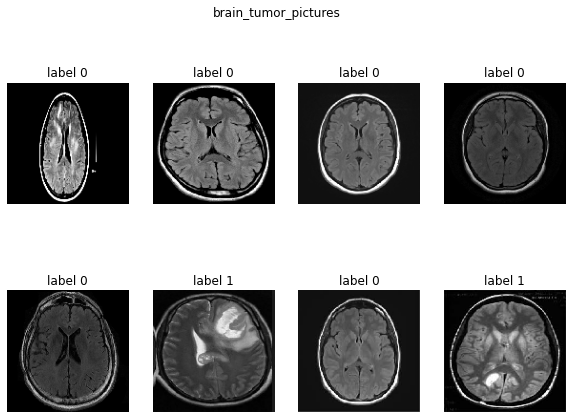

In [5]:
fig, ax = plt.subplots(2, 4, figsize=(10, 7))
fig.suptitle("brain_tumor_pictures")
for k in range(8):
    images, labels = train_ds.next()
    i, j = k//4, k%4
    ax[i, j].imshow(images[0])
    ax[i, j].set_title(f'label {int(labels[0])}')
    ax[i, j].axis('off')
plt.show()

## VGG19

In [117]:
from tensorflow.keras.layers.experimental import preprocessing

tf.keras.backend.clear_session()
input_shape = (height, width, 3)
base_model = tf.keras.applications.vgg19.VGG19(
    weights='imagenet', 
    include_top=False,
    input_shape=input_shape
)
base_model.trainable = False

model_vgg19 = tf.keras.Sequential()
model_vgg19.add(base_model)
#model_vgg19.add(tf.keras.layers.GlobalMaxPooling2D())
model_vgg19.add(tf.keras.layers.Flatten())
#model_vgg19.add(tf.keras.layers.Dropout(0.25))
#model_vgg19.add(tf.keras.layers.Dense(64, activation='relu'))
#model_vgg19.add(tf.keras.layers.Dense(32, activation='relu'))
#model_vgg19.add(tf.keras.layers.Dropout(0.1))

model_vgg19.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_vgg19.compile(loss='binary_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(0.01),
              metrics=['acc'])
model_vgg19.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 1)                 25089     
                                                                 
Total params: 20,049,473
Trainable params: 25,089
Non-trainable params: 20,024,384
_________________________________________________________________


In [118]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('model/vgg19_best.h5', monitor='acc', verbose=1, mode='max',save_best_only=True)
early = tf.keras.callbacks.EarlyStopping(monitor="acc", mode="max",restore_best_weights=True, patience=5)
callbacks_list = [checkpoint,early]

history = model_vgg19.fit(
        train_ds,
        validation_data=val_ds,
        epochs=25, 
        shuffle=True, 
        verbose=True,
        callbacks=callbacks_list)

Epoch 1/25
4/4 [==============================] - ETA: 0s - loss: 9.1010 - acc: 0.5296
Epoch 1: acc improved from -inf to 0.52964, saving model to model\vgg19_best.h5
4/4 [==============================] - 25s 6s/step - loss: 9.1010 - acc: 0.5296 - val_loss: 11.6612 - val_acc: 0.3800
Epoch 2/25
4/4 [==============================] - ETA: 0s - loss: 7.0924 - acc: 0.4862
Epoch 2: acc did not improve from 0.52964
4/4 [==============================] - 24s 6s/step - loss: 7.0924 - acc: 0.4862 - val_loss: 8.3656 - val_acc: 0.6200
Epoch 3/25
4/4 [==============================] - ETA: 0s - loss: 5.3547 - acc: 0.6601
Epoch 3: acc improved from 0.52964 to 0.66008, saving model to model\vgg19_best.h5
4/4 [==============================] - 24s 6s/step - loss: 5.3547 - acc: 0.6601 - val_loss: 1.5001 - val_acc: 0.7200
Epoch 4/25
4/4 [==============================] - ETA: 0s - loss: 4.0429 - acc: 0.5652
Epoch 4: acc did not improve from 0.66008
4/4 [==============================] - 25s 6s/step - 

In [119]:
model_vgg19.evaluate(val_ds)

1/1 [==============================] - 11s 11s/step - loss: 0.0180 - acc: 1.0000


[0.01803162507712841, 1.0]

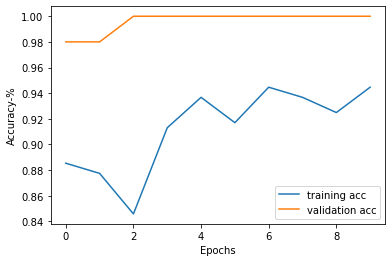

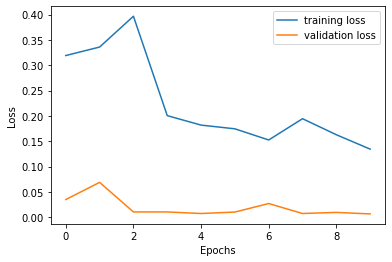

In [124]:
# plot learning curve
def plot_learning_curve(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, label='training acc')
    plt.plot(epochs, val_acc, label='validation acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy-%')
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, label='training loss')
    plt.plot(epochs, val_loss, label='validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

plot_learning_curve(history)

## Image Augmentation

In [137]:
datagen = ImageDataGenerator(
        rescale=1./255.,
        #validation_split=0.2,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        rotation_range=30,
        horizontal_flip=True,
        brightness_range=(0.5, 1.0)
        )
aug_train_ds = datagen.flow_from_directory(
        data_dir,
        batch_size=64,
        #subset="training",
        shuffle=True,
        class_mode='binary',
        target_size=(height, width),
        classes={'no': 0., 'yes': 1.}
        )

Found 253 images belonging to 2 classes.


In [126]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='acc', factor=0.3,
                              patience=2, min_lr=0.0000001)
callbacks_list = [checkpoint,early,reduce_lr]

history = model_vgg19.fit(
        aug_train_ds,
        validation_data=val_ds,
        epochs=15, 
        verbose=True,
        callbacks=callbacks_list)

Epoch 1/5
4/4 [==============================] - ETA: 0s - loss: 0.1710 - acc: 0.9289
Epoch 1: acc did not improve from 0.94466
4/4 [==============================] - 25s 6s/step - loss: 0.1710 - acc: 0.9289 - val_loss: 0.0080 - val_acc: 1.0000 - lr: 0.0030
Epoch 2/5
4/4 [==============================] - ETA: 0s - loss: 0.1221 - acc: 0.9644
Epoch 2: acc improved from 0.94466 to 0.96443, saving model to model\vgg19_best.h5
4/4 [==============================] - 25s 7s/step - loss: 0.1221 - acc: 0.9644 - val_loss: 0.0081 - val_acc: 1.0000 - lr: 0.0030
Epoch 3/5
4/4 [==============================] - ETA: 0s - loss: 0.1398 - acc: 0.9368
Epoch 3: acc did not improve from 0.96443
4/4 [==============================] - 24s 6s/step - loss: 0.1398 - acc: 0.9368 - val_loss: 0.0069 - val_acc: 1.0000 - lr: 0.0030
Epoch 4/5
4/4 [==============================] - ETA: 0s - loss: 0.1327 - acc: 0.9407
Epoch 4: acc did not improve from 0.96443
4/4 [==============================] - 24s 6s/step - loss

In [127]:
ypred = model_vgg19.predict(val_ds[0][0])
ypred = np.array([1 if x > 0.5 else 0 for x in ypred])
#ypred = ypred.astype(int)
ytest = val_ds[0][-1]

print(confusion_matrix(ytest, ypred))
print('VGG19_CNN:\n',classification_report(ypred,ytest))

2/2 [==============================] - 11s 4s/step
[[19  0]
 [ 0 31]]
VGG19_CNN:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      1.00      1.00        31

    accuracy                           1.00        50
   macro avg       1.00      1.00      1.00        50
weighted avg       1.00      1.00      1.00        50



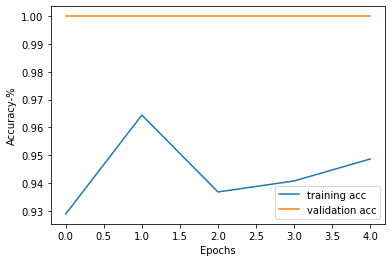

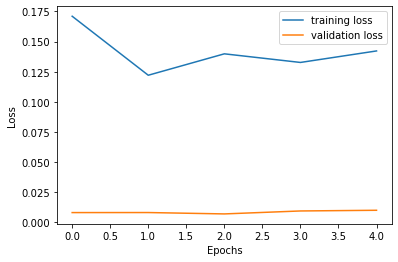

In [128]:
plot_learning_curve(history)

In [ ]:
# total_false = np.where((ypred == ytest) == False)[0]
# fig, ax = plt.subplots(1, 5, figsize=(12, 6))
# ax = ax.ravel()
# for n,i in enumerate(total_false):
#     fig = plt.figure(figsize=(15,15))
#     plt.subplot(1,5,n+1)
    
#     image = plt.imshow(val_ds[0][0][i])
#     plt.show(image)
#     plt.title(f'real {int(ytest[i])}', c='red')

## Inception v3

In [129]:
# inception v3
height = 299
width = 299

tf.keras.backend.clear_session()
input_shape = (height, width, 3)
base_model = tf.keras.applications.InceptionV3(
    weights='imagenet', 
    include_top=False, 
    input_shape=input_shape
)
base_model.trainable = False

model_inceptionv3 = tf.keras.Sequential()
model_inceptionv3.add(base_model)
model_inceptionv3.add(tf.keras.layers.Flatten())
#model_inceptionv3.add(tf.keras.layers.Dropout(0.2))
#model_inceptionv3.add(tf.keras.layers.Dense(8, activation='relu'))
model_inceptionv3.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_inceptionv3.compile(
                    loss='binary_crossentropy', 
                    optimizer=tf.keras.optimizers.Adam(0.001),
                    metrics=['acc']
)
model_inceptionv3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 131072)            0         
                                                                 
 dense (Dense)               (None, 1)                 131073    
                                                                 
Total params: 21,933,857
Trainable params: 131,073
Non-trainable params: 21,802,784
_________________________________________________________________


In [133]:
# train inception v3
checkpoint = tf.keras.callbacks.ModelCheckpoint('model/inceptionv3_best.h5', monitor='acc', verbose=1, mode='max',save_best_only=True)
early = tf.keras.callbacks.EarlyStopping(monitor="acc", mode="max",restore_best_weights=True, patience=5)
callbacks_list = [checkpoint,early]

history = model_inceptionv3.fit(
        train_ds,
        validation_data=val_ds,
        epochs=25, 
        #shuffle=True, 
        verbose=True,
        callbacks=callbacks_list)

Epoch 1/25
4/4 [==============================] - ETA: 0s - loss: 2.5872 - acc: 0.6946
Epoch 1: acc improved from -inf to 0.69458, saving model to model\inceptionv3_best.h5
4/4 [==============================] - 27s 9s/step - loss: 2.5872 - acc: 0.6946 - val_loss: 3.1927 - val_acc: 0.7400
Epoch 2/25
4/4 [==============================] - ETA: 0s - loss: 3.3752 - acc: 0.7438
Epoch 2: acc improved from 0.69458 to 0.74384, saving model to model\inceptionv3_best.h5
4/4 [==============================] - 32s 8s/step - loss: 3.3752 - acc: 0.7438 - val_loss: 2.1157 - val_acc: 0.8800
Epoch 3/25
4/4 [==============================] - ETA: 0s - loss: 0.9216 - acc: 0.8818
Epoch 3: acc improved from 0.74384 to 0.88177, saving model to model\inceptionv3_best.h5
4/4 [==============================] - 27s 9s/step - loss: 0.9216 - acc: 0.8818 - val_loss: 2.7033 - val_acc: 0.8400
Epoch 4/25
4/4 [==============================] - ETA: 0s - loss: 1.7711 - acc: 0.8030
Epoch 4: acc did not improve from 0.8

In [134]:
model_inceptionv3.evaluate(val_ds)

1/1 [==============================] - 4s 4s/step - loss: 1.1282 - acc: 0.9400


[1.1281818151474, 0.9399999976158142]

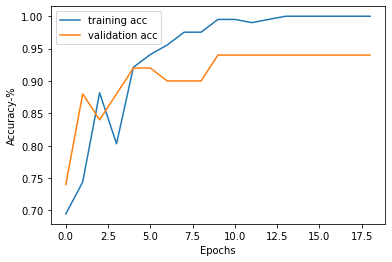

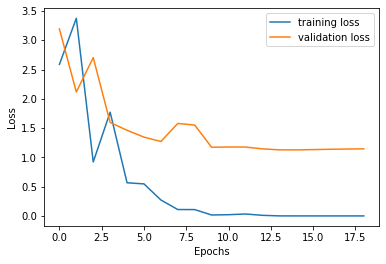

In [135]:
plot_learning_curve(history)

In [139]:
# datagen = ImageDataGenerator(
#         rescale=1./255.,
#         #validation_split=0.2,
#         width_shift_range=0.1,
#         height_shift_range=0.1,
#         shear_range=0.1,
#         zoom_range=0.1,
#         horizontal_flip=True,
#         brightness_range=(0.5, 1)
#         )

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='acc', factor=0.3,
                              patience=2, min_lr=0.0000001)
callbacks_list = [checkpoint,early,reduce_lr]

history = model_inceptionv3.fit(
        aug_train_ds,
        validation_data=val_ds,
        epochs=15, 
        #shuffle=True, 
        verbose=True,
        callbacks=callbacks_list)

Epoch 1/10
4/4 [==============================] - ETA: 0s - loss: 0.4177 - acc: 0.9209
Epoch 1: acc did not improve from 1.00000
4/4 [==============================] - 36s 9s/step - loss: 0.4177 - acc: 0.9209 - val_loss: 0.2942 - val_acc: 0.9600 - lr: 3.0000e-04
Epoch 2/10
4/4 [==============================] - ETA: 0s - loss: 0.8813 - acc: 0.9051
Epoch 2: acc did not improve from 1.00000
4/4 [==============================] - 43s 12s/step - loss: 0.8813 - acc: 0.9051 - val_loss: 0.3148 - val_acc: 0.9600 - lr: 3.0000e-04
Epoch 3/10
4/4 [==============================] - ETA: 0s - loss: 0.5921 - acc: 0.8933 
Epoch 3: acc did not improve from 1.00000
4/4 [==============================] - 46s 11s/step - loss: 0.5921 - acc: 0.8933 - val_loss: 0.4764 - val_acc: 0.9200 - lr: 3.0000e-04
Epoch 4/10
4/4 [==============================] - ETA: 0s - loss: 0.3015 - acc: 0.9368
Epoch 4: acc did not improve from 1.00000
4/4 [==============================] - 38s 10s/step - loss: 0.3015 - acc: 0.936

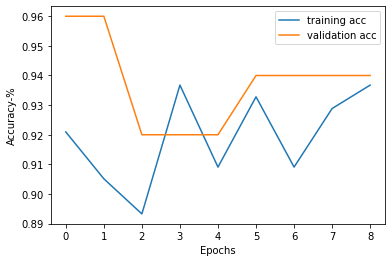

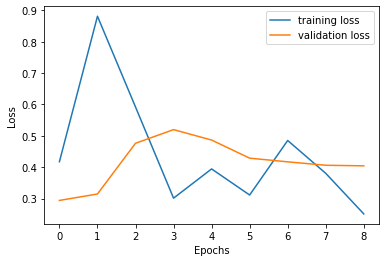

In [140]:
plot_learning_curve(history)

In [141]:
ypred = model_inceptionv3.predict(val_ds[0][0])
ypred = np.array([1 if x > 0.5 else 0 for x in ypred])
#ypred = ypred.astype(int)
ytest = val_ds[0][-1]

print('Confusion_Matrix:\n',confusion_matrix(ytest, ypred))
print('\nClassification_report:\n',classification_report(ypred,ytest))

2/2 [==============================] - 20s 2s/step
Confusion_Matrix:
 [[18  1]
 [ 3 28]]

Classification_report:
               precision    recall  f1-score   support

           0       0.95      0.86      0.90        21
           1       0.90      0.97      0.93        29

    accuracy                           0.92        50
   macro avg       0.93      0.91      0.92        50
weighted avg       0.92      0.92      0.92        50

